<a target="_blank" href="https://colab.research.google.com/drive/13GY80rzw5xwWj_RlSxtSrTXCIdwkXco3#scrollTo=y2WrJNhe4G8T&uniqifier=1">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


# **Using tf.data**

In [30]:
# Import packge
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import keras
from tensorflow.keras import layers
import os

# 1.download data dog and cat in github

[data cats and dogs](https://github.com/thanhhoai2k4/data_cats_dogs)
 from github.

In [31]:
! git clone https://github.com/thanhhoai2k4/data_cats_dogs

fatal: destination path 'data_cats_dogs' already exists and is not an empty directory.


## 1.1 Creat fother for train
**path_current**
<ul>
  <li>cats</li>
  <li>dogs</li>
</ul>

<p>creat fother if they don't exist </p>

In [32]:
current  = os.getcwd()
pathTrainData = os.path.join(current, "train_data")



for element in ["dogs", "cats"]:
  pathtrain = os.path.join(pathTrainData, element)
  if os.path.exists(pathtrain) is not True:
    os.makedirs(pathtrain)

In [33]:
import shutil
# path to image for split train and val  </content/data_cats_dogs/train/filename.jpg'>
pathImage = os.path.join(current,"data_cats_dogs","train")
listFiles = os.listdir(pathImage)

for filename in listFiles:
  source = os.path.join(pathImage, filename)
  if filename.startswith("dog"):
    destination = os.path.join(pathTrainData,"dogs",filename)
  else:
    destination = os.path.join(pathTrainData,"cats",filename)
  shutil.copyfile(source, destination)

In [34]:
# information
print("Image train dogs: ", len(os.listdir(os.path.join(pathTrainData,"dogs"))))
print("Image val cats: ", len(os.listdir(os.path.join(pathTrainData,"cats"))))

Image train dogs:  12500
Image val cats:  12500


# 2.Build input pipeline

In [35]:
import pathlib
image_count = len(listFiles)
data_dir = "/content/train_data"
data_dir = pathlib.Path(data_dir) # conver string to Path sys
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [36]:
for f in list_ds.take(5):
  print(f.numpy())

b'/content/train_data/cats/cat.3373.jpg'
b'/content/train_data/dogs/dog.3171.jpg'
b'/content/train_data/dogs/dog.4738.jpg'
b'/content/train_data/dogs/dog.6560.jpg'
b'/content/train_data/dogs/dog.7550.jpg'


In [37]:
class_names = np.array(sorted([item.name for item in data_dir.glob("*") if item.name != "LICENSE.txt"]))
class_names

array(['cats', 'dogs'], dtype='<U4')

## 2.1split data

In [38]:
val_size = int(image_count*0.2) # 20% val 80% training
train_ds = list_ds.skip(val_size) # shuffle 20% data
val_ds = list_ds.take(val_size)

## 2.2leght train and val

In [39]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

20000
5000


In [40]:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.keras.utils.to_categorical(0,2) if parts[-2] == "cats" else tf.keras.utils.to_categorical(1,2)



In [41]:
for i in train_ds.take(10):
  print("{}".format(get_label(i)))

[1. 0.]
[0. 1.]
[1. 0.]
[1. 0.]
[1. 0.]
[0. 1.]
[0. 1.]
[0. 1.]
[1. 0.]
[0. 1.]


In [42]:
img_height = 224
img_width = 224
def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  img = tf.image.resize(img, [img_height, img_width])
  return img

In [43]:
def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [44]:
import scipy.ndimage as ndimage

# Convert data augment
def random_rotate_image(image):
  pass

In [45]:
# using `num_parallel_call` so mutltiple images are loaded /processed parallel
train_ds = train_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

In [46]:
for image,label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  [1. 0.]


In [47]:
def configure_for_performance(ds):
  #ds = ds.cache() with data big done using.
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(32)
  ds = ds.repeat()
  ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

## 2.3Matplot data

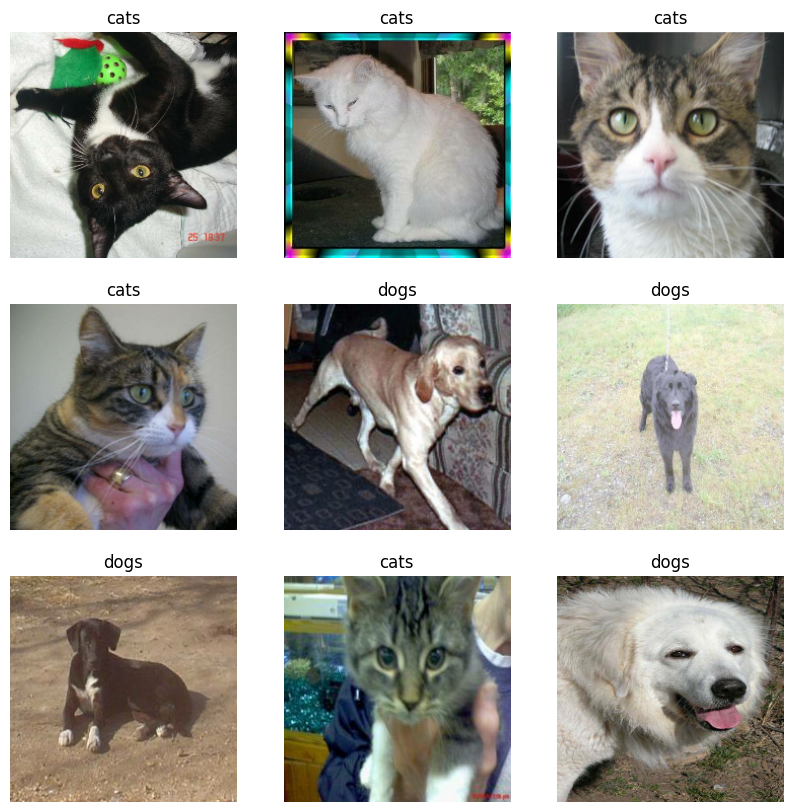

In [48]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[np.argmax(label)])
  plt.axis("off")

# 3.Train model using Backbone VGG16

In [49]:
# define packge
from keras.applications import VGG16
from keras.layers import Input
from keras.layers import Flatten
from keras.layers import Dense
from keras.models import Model
from keras.layers import Dropout

In [50]:
baseModel = VGG16(weights='imagenet', include_top=False,\
                                        input_tensor=Input(shape=(224,224,3)))
fcHead = baseModel.output # get output VGG16
fcHead = Flatten()(fcHead) # Flatten

# Add FC
fcHead = Dense(200,activation="relu")(fcHead)
fcHead = Dense(100, activation="relu")(fcHead)
fcHead = Dense(2, activation="softmax")(fcHead) # sotfmax

# build model input baseModel output fcHead
model = Model(inputs=baseModel.input, outputs=fcHead)
for layer in baseModel.layers:
  layer.trainable = False

In [51]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

## Note:
<h4> Looking</h4>
<ul  >
  <li> loss:  <a href="https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy">tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)</a> </li>
  <li> metrics:  <a href="https://www.tensorflow.org/api_docs/python/tf/keras/metrics/SparseCategoricalAccuracy">tf.keras.metrics.SparseCategoricalAccuracy()</a> </li>
</ul>



<h4> Learning more </h4>
<ul>
  <li><h3>Loss: <a href="https://www.tensorflow.org/api_docs/python/tf/keras/losses"> https://www.tensorflow.org/api_docs/python/tf/keras/losses</a> </h3></li>

  <li><h3>Loss: <a href="https://www.tensorflow.org/api_docs/python/tf/keras/metrics"> https://www.tensorflow.org/api_docs/python/tf/keras/metrics</a> </h3></li>

<ul>

## 3.1 Training model

In [52]:

model.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=[tf.keras.metrics.CategoricalAccuracy()])
# Note:
#  +Loss
#  +metrics

history = model.fit(train_ds,steps_per_epoch=(image_count*0.8)//64,
                    validation_data=val_ds,validation_steps=(image_count*0.2)//64,
                    epochs=20, verbose=1)

Epoch 1/20
312/312 [==============================] - 58s 180ms/step - loss: 0.3691 - categorical_accuracy: 0.9400 - val_loss: 0.1637 - val_categorical_accuracy: 0.9563
Epoch 2/20
312/312 [==============================] - 55s 175ms/step - loss: 0.1498 - categorical_accuracy: 0.9593 - val_loss: 0.1310 - val_categorical_accuracy: 0.9579
Epoch 3/20
312/312 [==============================] - 64s 207ms/step - loss: 0.0270 - categorical_accuracy: 0.9921 - val_loss: 0.1098 - val_categorical_accuracy: 0.9683
Epoch 4/20
312/312 [==============================] - 55s 177ms/step - loss: 0.0154 - categorical_accuracy: 0.9954 - val_loss: 0.1060 - val_categorical_accuracy: 0.9683
Epoch 5/20
312/312 [==============================] - 64s 206ms/step - loss: 0.0063 - categorical_accuracy: 0.9989 - val_loss: 0.1151 - val_categorical_accuracy: 0.9659
Epoch 6/20
312/312 [==============================] - 56s 180ms/step - loss: 0.0031 - categorical_accuracy: 0.9996 - val_loss: 0.1028 - val_categorical_acc

## 3.2 Plot model

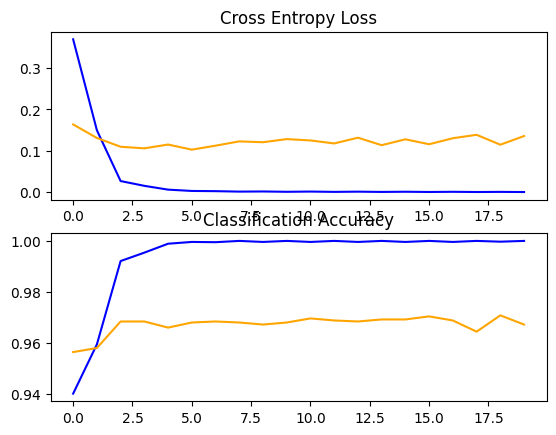

In [61]:
def summarize_diagnostics(history):
 # plot loss
  plt.subplot(211)
  plt.title('Cross Entropy Loss')
  plt.plot(history.history['loss'], color='blue', label='train')
  plt.plot(history.history['val_loss'], color='orange', label='test')
  # plot accuracy
  plt.subplot(212)
  plt.title('Classification Accuracy')
  plt.plot(history.history['categorical_accuracy'], color='blue', label='train')
  plt.plot(history.history['val_categorical_accuracy'], color='orange', label='test')


summarize_diagnostics(history)

In [54]:
model.save("My_Model.keras")

# 4. Prediction


## 4.1 Load model

In [55]:
# Load model
filePathModel = "My_Model.keras"
from tensorflow.keras.models import load_model

def loadModel(filePathModel):
  return load_model(filePathModel)
model_Loaded = load_model(filePathModel)

#Summary model
model_Loaded.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

## 3.2 Predict image

In [65]:
# Load image
def load_IMG(filePath):
  img = tf.io.read_file(filePath)
  img = tf.io.decode_jpeg(img, channels=3)
  img = tf.image.resize(img,[224,224])
  return img.numpy()

In [67]:
a = load_IMG("1.jpeg")
print(type(a))

<class 'numpy.ndarray'>


1/1 [==============================] - 1s 1s/step


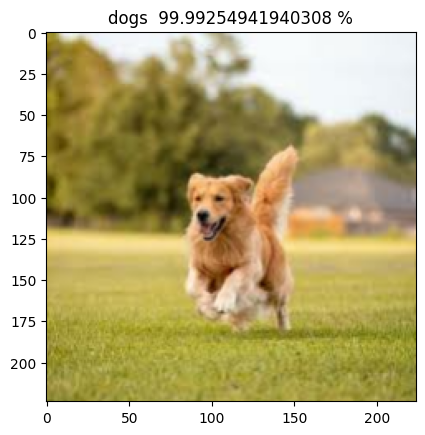

In [69]:
# predict with a image
def predictionImg(model,filePath):
  img = load_IMG(filePath) # load image type(array)
  img = np.reshape(img, [1,224,224,3]) # reshape image to [number_img, width, height, channel]
  prd = model.predict(img)
  name = class_names[np.argmax(prd)]
  plt.imshow(img[0].astype("uint8"))
  plt.title(name +"  "+str(np.max(prd)*100) + " %")

propa = predictionImg(model_Loaded, "1.jpeg")

**i have a model with accracy 95%**

Contact me in [***here***](https://github.com/thanhhoai2k4)